In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt
import numpy as np


from dataset import train_split_files

from utils import clear_memory

from config import (
    DATA_DIR,
    MODEL_PATH,
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    EPOCHS,
    BATCH_SIZE,
    LR,
    SPLIT,
	UNROLL_STEPS
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torch.utils.data import Dataset
import json
from create_structured_grids import create_structured_grids

DATA_DIR = "data/fluid-openfoam/"
X_CELLS = 128
Y_CELLS = 64
T_STRIDE = 20
UNROLL_STEPS = 5

class CFDDatasetBPTT(Dataset):
    def __init__(self, file_paths, unroll_steps=UNROLL_STEPS, x_cells=X_CELLS, y_cells=Y_CELLS, t_stride=T_STRIDE):
        self.data = []
        self.file_paths = file_paths
        self.unroll_steps = unroll_steps
        self.x_cells = x_cells
        self.y_cells = y_cells
        self.t_stride = t_stride # The gap between each prediction step
        self._load_data()

    def _load_data(self):
        for file_path in self.file_paths:
            # Data loading and channel creation is the same as before
            data = np.load(file_path)
            params_str = data['parameters'].item()
            params = json.loads(params_str)
            domain = params['domain']
            viscosity = params['kinematic_viscosity']
            width = domain['width']
            height = domain['height']
            internal_coords = data['internal_coordinates']
            boundary_coords = data['boundary_coordinates']
            internal_values = data['Solver-Mesh-2D-Internal']
            boundary_values = data['Solver-Mesh-2D-Boundaries']
            timesteps = internal_values.shape[0]
            domain['h_cells'] = self.x_cells
            domain['v_cells'] = self.y_cells
            domain['dx'] = domain['width'] / domain['h_cells']
            domain['dy'] = domain['height'] / domain['v_cells']
            internal_grid, boundary_grid = create_structured_grids(
                internal_coords, internal_values, boundary_coords, boundary_values, domain
            )
            internal_mask = ~np.isnan(internal_grid[:, :, :, 0:1])
            boundary_mask = ~np.isnan(boundary_grid[:, :, :, 0:1])
            internal_grid = np.nan_to_num(internal_grid, nan=0.0)
            boundary_grid = np.nan_to_num(boundary_grid, nan=0.0)
            viscosity_channel = np.full((timesteps, self.y_cells, self.x_cells, 1), viscosity)
            width_channel = np.full((timesteps, self.y_cells, self.x_cells, 1), width)
            height_channel = np.full((timesteps, self.y_cells, self.x_cells, 1), height)
            data_concatenated = np.concatenate([
                internal_grid, boundary_grid, internal_mask, boundary_mask,
                viscosity_channel, width_channel, height_channel
            ], axis=-1, dtype=np.float32)

            sequence_len = self.unroll_steps * self.t_stride
            for i in range(0, timesteps - sequence_len, self.t_stride):
                # The input is the state at time `i`
                x = data_concatenated[i]
                # The target is a sequence of states at t+stride, t+2*stride, ...
                y_sequence = data_concatenated[i+self.t_stride : i+sequence_len+1 : self.t_stride]
                self.data.append((x, y_sequence))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        # x shape: (H, W, C) -> (C, H, W)
        x = np.transpose(x, (2, 0, 1))
        # y shape: (T, H, W, C) -> (T, C, H, W)
        y = np.transpose(y, (0, 3, 1, 2))
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

DATA_DIR = "../data/fluid-openfoam/"
SPLIT = .8
train_files, val_files = train_split_files(data_dir=DATA_DIR, split=SPLIT)
train_files = train_files
val_files = val_files

train_dataset = CFDDatasetBPTT(file_paths=train_files)
val_dataset = CFDDatasetBPTT(file_paths=val_files)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Found 199 simulations.
Splitting into 159 training and 40 validation files.


In [3]:
example_params_str = "{'domain': {'x_min': 0.0, 'y_min': 0.0, 'width': 6.0, 'height': 3.0}, 'obstacle': {'x_min': 2.25, 'x_max': 3.375, 'height': 1.5}, 'inlet_velocity': [4.7, 0, 0], 'kinematic_viscosity': 0.08286427728546843, 'simulation_control': {'endTime': 5.0, 'deltaT': 0.01, 'writeInterval': 20}, 'grading': {'h1_cells': 48, 'h2_cells': 24, 'h3_cells': 56, 'v1_cells': 32, 'v2_cells': 32}}"

Unroll Steps: 5
x shape: torch.Size([32, 9, 64, 128]), y shape: torch.Size([32, 5, 9, 64, 128])


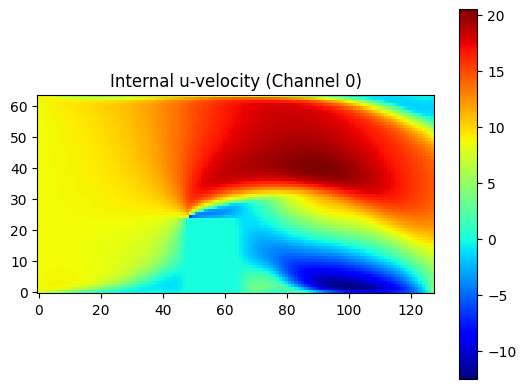

In [12]:
# In[4]:
#sample the train_loader
sample = next(iter(train_loader))
x, y = sample

u_velocity_field = x[0, 0, :, :] 

print(f"Unroll Steps: {UNROLL_STEPS}")
print(f"x shape: {x.shape}, y shape: {y.shape}")

plt.imshow(u_velocity_field.numpy(), cmap='jet', origin="lower")
plt.colorbar()
plt.title("Internal u-velocity (Channel 0)")
plt.show()

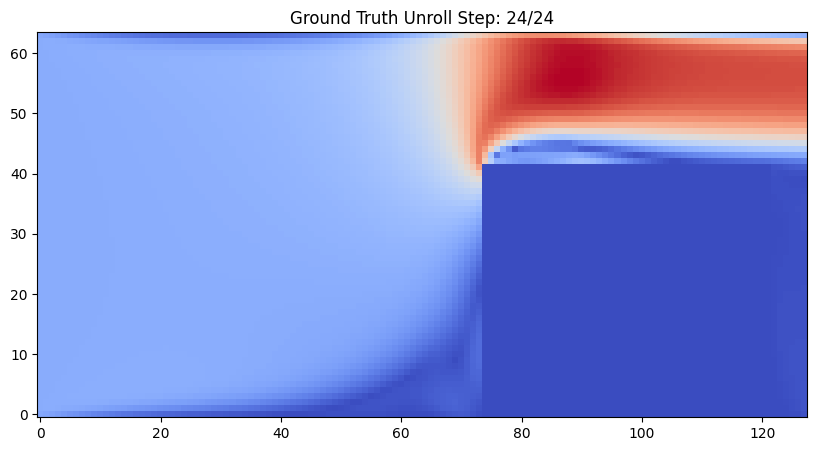

In [13]:
from IPython.display import clear_output
import time

# --- Setup for Visualization ---
# Define the number of unroll steps you want to visualize
UNROLL_STEPS_VIZ = 24

file_path = np.random.choice(train_files)
# Create a temporary BPTT dataset and loader specifically for this visualization
test_dataset = CFDDatasetBPTT(file_paths=[file_path], unroll_steps=UNROLL_STEPS_VIZ)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Get just one sample. 
# x shape: (1, C, H, W)
# y shape: (1, T, C, H, W), where T is UNROLL_STEPS_VIZ
try:
    x, y_sequence = next(iter(test_loader))
except StopIteration:
    print("Validation dataset is empty. Cannot visualize.")
    # Handle the empty dataset case gracefully.
    y_sequence = None

if y_sequence is not None:
    # --- Animation Loop ---
    fig, ax = plt.subplots(figsize=(10, 5))

    # The new loop iterates over the TIME dimension (dim 1) of the y_sequence tensor
    for t_step in range(y_sequence.shape[1]):
        
        # Get the current frame from the sequence
        # y_sequence[0, t_step] has shape (C, H, W)
        current_frame = y_sequence[0, t_step]

        # Select the u-velocity (channel 0) and v-velocity (channel 1)
        u_velocity = current_frame[0, :, :].numpy()
        v_velocity = current_frame[1, :, :].numpy()

        # Calculate the velocity magnitude
        field_to_plot = np.sqrt(u_velocity**2 + v_velocity**2)

        # Clear previous output and axes
        clear_output(wait=True)
        ax.clear()

        # Draw the new image
        im = ax.imshow(field_to_plot, cmap='coolwarm', origin="lower")
        
        # Update title for the current step in the unrolled sequence
        ax.set_title(f"Ground Truth Unroll Step: {t_step + 1}/{UNROLL_STEPS_VIZ}")

        # Display the updated plot
        display(fig)
        
        # Pause for animation effect
        time.sleep(0.2)

    # Clean up the figure
    plt.close(fig)

In [14]:
def masked_mse_loss(pred, target):
    # The internal fluid mask is the 5th channel (index 4)
    valid_mask = target[:, 4:5, :, :] 

    # We only compute loss on the first 2 channels (u, v internal velocity)
    pred_fields = pred[:, :2, :, :]
    target_fields = target[:, :2, :, :]
    
    squared_error = (pred_fields - target_fields)**2
    masked_squared_error = squared_error * valid_mask
    
    # Calculate the mean loss only over the number of valid pixels
    loss = masked_squared_error.sum() / (valid_mask.sum() + 1e-8)
    return loss

In [15]:
def scaled_masked_mse_loss(pred, target):
    """
    Calculates MSE loss scaled by the magnitude of the target velocity field.
    """
    # The internal fluid mask is the 5th channel (index 4)
    valid_mask = target[:, 4:5, :, :] 

    # We compute loss on the first 2 channels (u, v internal velocity)
    pred_fields = pred[:, :2, :, :]
    target_fields = target[:, :2, :, :]
    
    squared_error = (pred_fields - target_fields)**2
    masked_squared_error = squared_error * valid_mask
    
    # --- Loss Scaling ---
    target_norm_sq = (target_fields**2) * valid_mask
    scaling_factor = target_norm_sq.mean() + 1e-8
    
    loss = masked_squared_error.sum() / (valid_mask.sum() + 1e-8)
    normalized_loss = loss / scaling_factor
    
    return normalized_loss

In [22]:
from model import ResidualUNet

MODEL_SAVE_PATH = f"models/ResidualUNet_CFD_UNROLL_{UNROLL_STEPS}.pth"

restart_model_checkpoint = None

os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

LR = 1e-4
EPOCHS = 100
BATCH_SIZE = 16

print(f"Configuration:")
print(f"  Device: {device}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LR}")
print(f"  Epochs: {EPOCHS}")
print(f"  Unroll Steps: {UNROLL_STEPS}")
print(f"  Model Save Path: {MODEL_SAVE_PATH}")

# Input: 2 vel + 2 bnd + 2 masks + 3 params = 9 channels
# Model predicts residual for: 2 velocity channels
model = ResidualUNet(in_channels=9, field_channels=2).to(device)
# criterion = masked_mse_loss
criterion = scaled_masked_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-8)

Configuration:
  Device: cuda
  Batch Size: 16
  Learning Rate: 0.0001
  Epochs: 100
  Unroll Steps: 5
  Model Save Path: models/ResidualUNet_CFD_UNROLL_5.pth


In [23]:
def unroll_loss(model, criterion, x, y, unroll_steps=UNROLL_STEPS):
    loss = torch.tensor(0.0, device=x.device)
    prev_step = x
    for i in range(unroll_steps):
        y_pred = model(prev_step)
        # y has shape (B, T, C, H, W), so y[:, i] gets the i-th ground truth step
        step_loss = criterion(y_pred, y[:, i])
        loss += step_loss
        prev_step = y_pred
    return loss / unroll_steps

def train_bptt(criterion, optimizer, scheduler, model, train_loader, val_loader, device, epochs, unroll_steps=UNROLL_STEPS):
    best_val_loss = float("inf")
    best_model_wts = None
    loss_history = {"train": [], "val": []}
    print(f"Starting BPTT training with {unroll_steps} unroll steps...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = unroll_loss(model, criterion, x, y, unroll_steps)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                loss = unroll_loss(model, criterion, x, y, unroll_steps)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"--> New best model found at epoch {epoch+1} with val loss {best_val_loss:.6f}")

        current_lr = optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.6f} | "
            f"Val Loss: {avg_val_loss:.6f} | "
            f"LR: {current_lr:.8f}"
        )
        loss_history["train"].append(avg_train_loss)
        loss_history["val"].append(avg_val_loss)
        scheduler.step()

    if best_model_wts:
        print(f"\nLoading best model weights with validation loss: {best_val_loss:.6f}")
        model.load_state_dict(best_model_wts)
    print("Finished BPTT training.")
    return loss_history

# if model doesn't exist or restart checkpoint exists
if (not os.path.exists(MODEL_SAVE_PATH)) or ([os.path.exists(restart_model_checkpoint) if restart_model_checkpoint else False][0]):
    loss_history = train_bptt(criterion, optimizer, scheduler, model, train_loader, val_loader, device, epochs=EPOCHS)
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nBest model saved to {MODEL_SAVE_PATH}")
else:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    model.eval()
    print(f"Model loaded from {MODEL_SAVE_PATH}")
    loss_history = None

Model loaded from models/ResidualUNet_CFD_UNROLL_5.pth


/tmp/ipykernel_77898/4222904066.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))


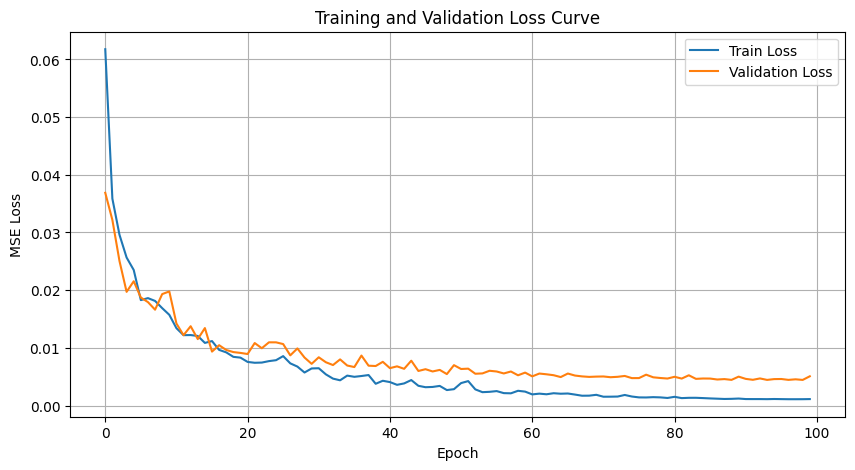

In [10]:
if loss_history:
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history["train"], label="Train Loss")
    plt.plot(loss_history["val"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training and Validation Loss Curve")
    plt.grid(True)
    plt.show()

In [31]:
def unroll_prediction(model, initial_condition, num_steps):
    model.eval()
    
    # Ensure the initial condition has a batch dimension and is on the correct device
    if initial_condition.dim() == 3:
        current_step = initial_condition.unsqueeze(0).to(device)
    else:
        current_step = initial_condition.to(device)
        
    predicted_sequence = []

    with torch.no_grad():
        for _ in range(num_steps):
            next_step_pred = model(current_step)
            predicted_sequence.append(next_step_pred.cpu())
            current_step = next_step_pred
            
    return torch.cat(predicted_sequence, dim=0)

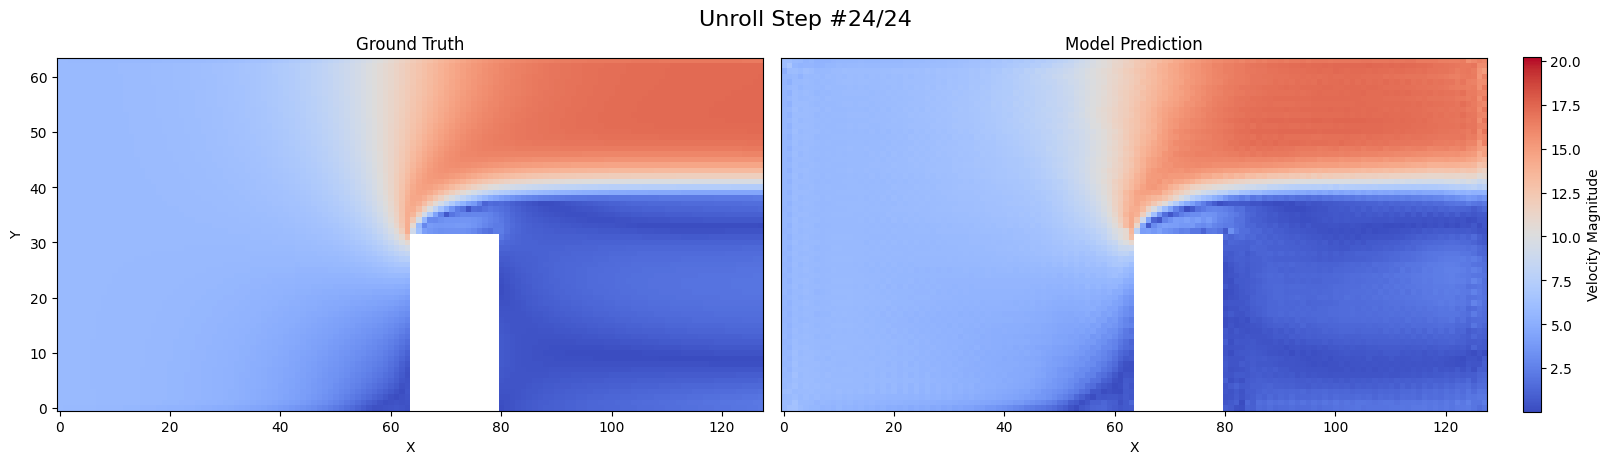

In [83]:
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import numpy as np

# --- 1. User Configuration & Setup ---
UNROLL_STEPS_VIZ = 24
file_path_viz = np.random.choice(val_files)

print(f"Visualizing a sequence of {UNROLL_STEPS_VIZ} steps from file: {os.path.basename(file_path_viz)}")

viz_dataset = CFDDatasetBPTT(file_paths=[file_path_viz], unroll_steps=UNROLL_STEPS_VIZ)
viz_loader = DataLoader(viz_dataset, batch_size=1, shuffle=False)

model.to(device)
model.eval()

# --- 2. Get Data and Run Prediction ---
try:
    input_x, ground_truth_sequence = next(iter(viz_loader))
except StopIteration:
    print("Visualization dataset is empty. Cannot visualize.")
    ground_truth_sequence = None

if ground_truth_sequence is not None:
    predicted_sequence = unroll_prediction(model, input_x, UNROLL_STEPS_VIZ)
    
    # --- NEW: Pre-calculate GLOBAL vmin and vmax from the ENTIRE ground truth sequence ---
    gt_sequence_np = ground_truth_sequence[0].numpy()
    gt_u_all = gt_sequence_np[:, 0, :, :]
    gt_v_all = gt_sequence_np[:, 1, :, :]
    gt_magnitude_all = np.sqrt(gt_u_all**2 + gt_v_all**2)
    
    # Apply the mask to the entire sequence before finding min/max
    mask_all = gt_sequence_np[:, 4, :, :]
    gt_magnitude_all[mask_all == 0] = np.nan
    
    # These are now the fixed color limits for the entire animation
    vmin_global = np.nanmin(gt_magnitude_all)
    vmax_global = np.nanmax(gt_magnitude_all)
    print(f"Fixed color range (vmin, vmax) based on ground truth: ({vmin_global:.2f}, {vmax_global:.2f})")
    
    # --- 3. Setup the Plot ONCE with the fixed color limits ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    # Get initial data just to initialize the imshow objects
    gt_mag_initial = gt_magnitude_all[0]
    
    im1 = axes[0].imshow(gt_mag_initial, cmap='coolwarm', origin='lower', vmin=vmin_global, vmax=vmax_global)
    axes[0].set_title('Ground Truth')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    im2 = axes[1].imshow(gt_mag_initial, cmap='coolwarm', origin='lower', vmin=vmin_global, vmax=vmax_global)
    axes[1].set_title('Model Prediction')
    axes[1].set_xlabel('X')
    axes[1].set_yticks([])

    # Create the colorbar ONCE
    cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), shrink=0.6, label='Velocity Magnitude', pad=0.025)
    
    # --- 4. Animation Loop ---
    for t_step in range(UNROLL_STEPS_VIZ):
        # Get current frames
        gt_frame = gt_sequence_np[t_step]
        pred_frame = predicted_sequence[t_step].numpy()

        # Calculate magnitudes for the current frame
        gt_magnitude = np.sqrt(gt_frame[0]**2 + gt_frame[1]**2)
        pred_magnitude = np.sqrt(pred_frame[0]**2 + pred_frame[1]**2)

        mask = gt_frame[4]
        gt_magnitude[mask == 0] = np.nan
        pred_magnitude[mask == 0] = np.nan
        
        # --- UPDATE the data in the existing image objects ---
        im1.set_data(gt_magnitude)
        im2.set_data(pred_magnitude)
        
        # NOTE: We NO LONGER call set_clim() here, as the limits are fixed.
        
        fig.suptitle(f'Unroll Step #{t_step + 1}/{UNROLL_STEPS_VIZ}', fontsize=16, y=0.875)
        
        clear_output(wait=True)
        display(fig)
        
        time.sleep(0.2)
        
    plt.close(fig)

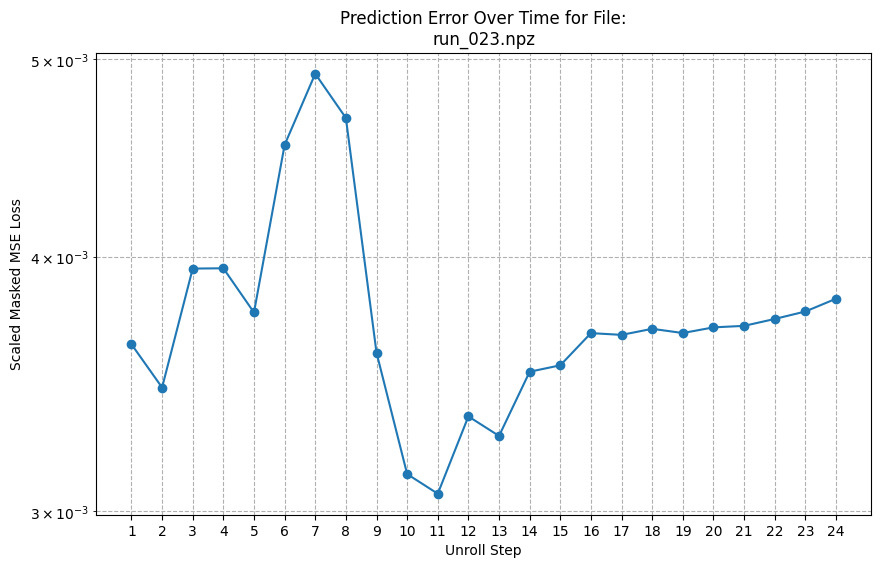

In [84]:
num_unroll_steps = ground_truth_sequence.shape[1] # Get T from (B, T, C, H, W)
loss_over_time = []

# --- Calculate the loss for each step in the sequence ---
for t in range(num_unroll_steps):
    # predicted_sequence is (T, C, H, W), so slice the time dimension
    pred_t = predicted_sequence[t].unsqueeze(0)
    # ground_truth_sequence is (B, T, C, H, W), so slice the time dimension
    gt_t = ground_truth_sequence[:, t]
    
    # Calculate the loss for this step
    loss = scaled_masked_mse_loss(pred_t.to(device), gt_t.to(device))
    loss_over_time.append(loss.item())

# --- Plot the results ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_unroll_steps + 1), loss_over_time, marker='o', linestyle='-')
plt.xlabel("Unroll Step")
plt.ylabel("Scaled Masked MSE Loss")
plt.title(f"Prediction Error Over Time for File:\n{os.path.basename(file_path_viz)}")
plt.xticks(range(1, num_unroll_steps + 1))
plt.yscale('log')
plt.grid(True, which='both', linestyle='--')
plt.show()

In [73]:
#convert notebook into script
!jupyter nbconvert --to script train_cfd_bptt.ipynb

[NbConvertApp] Converting notebook train_cfd_bptt.ipynb to script
[NbConvertApp] Writing 18839 bytes to train_cfd_bptt.py
